# 📊 Analisis Data E-Commerce Olist
**Nama**: Hafiz Mustafa Harras  
**Batch**: 29  
## 🧾 Pendahuluan

Olist adalah salah satu platform e-commerce terbesar di Brazil yang menghubungkan penjual, pembeli, dan partner logistik dalam transaksi dan pengiriman produk. Dataset Olist menyediakan data transaksi pelanggan secara komprehensif, termasuk informasi pesanan, produk, pembayaran, ulasan, dan pelanggan.

Dengan menganalisis data ini, kita dapat memahami perilaku konsumen, mengevaluasi tingkat kepuasan, serta mengidentifikasi peluang bisnis untuk meningkatkan penjualan dan loyalitas pelanggan.

### 🎯 Tujuan Analisis
- Mengukur distribusi dan kepuasan pelanggan berdasarkan review
- Mengidentifikasi kategori produk terlaris
- Menganalisis perilaku pembelian pelanggan dari waktu ke waktu (cohort & RFM)
- Mengamati tren penjualan dan pertumbuhan pelanggan aktif
- Memberikan rekomendasi strategis berbasis data


## 📂 Daftar Isi
1. [Import Library](#1-import-library)  
2. [Load Dataset dari SQLite Database](#2-load-dataset-dari-sqlite-database)  
3. [Data Preparation](#3-data-preparation)
4. [Exploratory Data Analysis (EDA)](#4-exploratory-data-analysis-(EDA))
   - [Distribusi Review Score](distribusi-review-score)  
   - [Top 10 Kategori Produk](#top-10-kategori-produk)
   - [Distribusi Metode Pembayaran](#distribusi-metode-pembayaran)
   - [Customer Demographic (State & City)](#customer-demographic-(state-&-city))
   - [Customer Behaviour (Spending Category)](#customer-behaviour-(spending-category))
5. [Cohort Analysis](#5-cohort-analysis)  
6. [Distribusi Kepuasan Pelanggan](#6-distribusi-kepuasan-pelanggan)  
7. [RFM Analysis & Segmentation](#7-rfm-analysis--segmentation)  
8. [Tren Penjualan Bulanan dan Harian](#8-tren-penjualan-bulanan-dan-harian)  
9. [Pareto Analysis](#9-pareto-analysis)  
10. [Pelanggan Baru vs Lama](#10-pelanggan-baru-vs-lama)  
11. [Kesimpulan dan Rekomendasi](#11-kesimpulan-dan-rekomendasi)
12. [Analisis Tambahan (Root Cause & Contrast)](#analisis-tambahan-(root-cause-&-contrast))

## 1. Import Library


Berikut adalah library-library yang digunakan dalam proyek ini:

- **Sqlite3**: Library bawaan Python untuk koneksi dan interaksi dengan file database SQLite (.db)
- **Pandas**: Library untuk manipulasi dan analisis data berbasis struktur tabel (DataFrame)
- **Numpy**: Library untuk operasi matematika dan komputasi numerik, sering digunakan untuk array dan perhitungan statistik
- **Matplotlib**: Library untuk visualisasi data dalam bentuk grafik dan plot di Python
- **Seaborn**: Library visualisasi data berbasis Matplotlib, dirancang untuk menghasilkan grafik statistik yang lebih informatif dan menarik
- **Datetime (as dt)**: Library bawaan Python untuk menangani tanggal dan waktu
- **StandardScaler (dari sklearn.preprocessing)**: Digunakan untuk melakukan standardisasi fitur (mengubah data agar memiliki mean = 0 dan standar deviasi = 1)
- **KMeans (dari sklearn.cluster)**: Algoritma unsupervised learning untuk melakukan *clustering* atau pengelompokan data berdasarkan kemiripan fitur


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

In [2]:
#Cek nama tables dalam database

db_file = "foo.db"  # Path 

try:
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Execute a query to get the list of tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    if tables:
        print(f"Tabel-tabel dalam database '{db_file}':")
        for table in tables:
            print(table[0])  # Print the table name
    else:
        print(f"Tidak ada tabel yang ditemukan dalam database '{db_file}'.")

except sqlite3.Error as e:
    print(f"Terjadi kesalahan database: {e}")

finally:
    if conn:
        conn.close()
        print("Koneksi database ditutup.")

Tabel-tabel dalam database 'foo.db':
olist_customers_dataset
olist_geolocation_dataset
olist_orders_dataset
olist_order_items_dataset
olist_order_payments_dataset
olist_order_reviews_dataset
olist_products_dataset
olist_sellers_dataset
product_category_name_translation
Koneksi database ditutup.


## 2. Load Dataset dari SQLite Database

In [3]:
# 1 Database path untuk koneksi di google colab
#db_file = "/content/drive/My Drive/Data Analysis/File Notebook Python Growia/Final_project/foo.db"
# 2 Database path untuk koneksi di jupyter notebook
db_file = "foo.db"  # Path 

# Connect to Database and Load Data
conn = None  # Initialize conn outside the try block
try:
    conn = sqlite3.connect(db_file)
    
    # Load DataFrames
    orders = pd.read_sql("SELECT * FROM olist_orders_dataset", conn)
    order_items = pd.read_sql("SELECT * FROM olist_order_items_dataset", conn)
    products = pd.read_sql("SELECT * FROM olist_products_dataset", conn)
    customers = pd.read_sql("SELECT * FROM olist_customers_dataset", conn)
    payments = pd.read_sql("SELECT * FROM olist_order_payments_dataset", conn)
    reviews = pd.read_sql("SELECT * FROM olist_order_reviews_dataset", conn)
    order_products = pd.read_sql("SELECT * FROM product_category_name_translation", conn)

    print("Datasets loaded successfully!")

except sqlite3.Error as e:
    print(f"Database error: {e}")

finally:
    if conn:
        conn.close()
        print("Database connection closed.")

Datasets loaded successfully!
Database connection closed.


## Memahami struktur tabel dataset beserta key connections

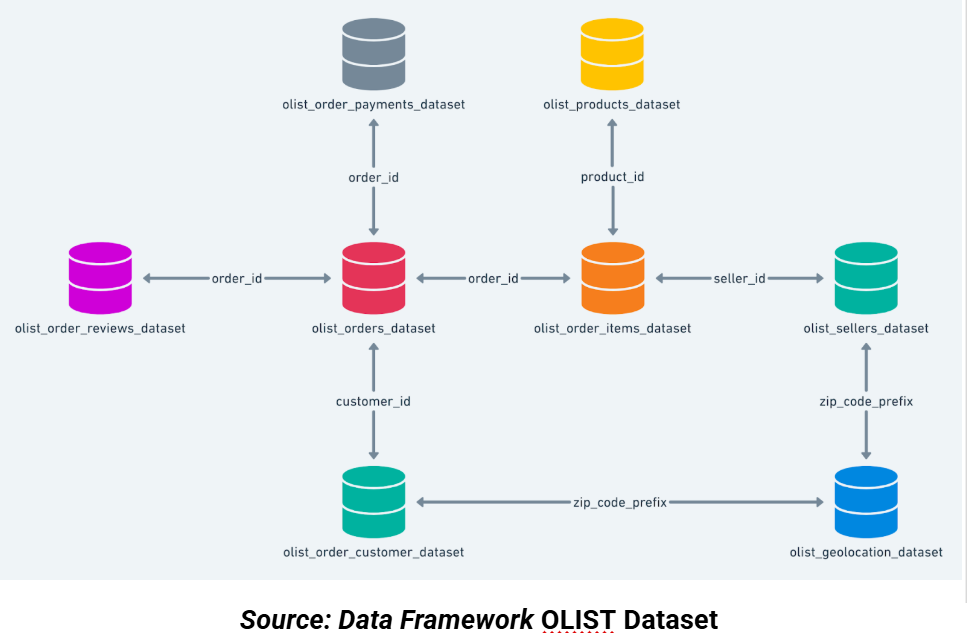

## Deskripsi Dataset

Dataset Olist merupakan kumpulan data transaksi yang mencakup:
- Informasi pelanggan (`customers`)
- Penjualan (`orders`, `order_items`, `order_payments`)
- Produk dan kategori (`products`, `product_category_name_translation`)
- Penilaian (`order_reviews`)
- Informasi penjual (`sellers`)
- Geolokasi (`geolocation`)

## 3. Data Preparation


In [4]:
orders.columns


Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [5]:
# Convert datetime columns
date_columns = [
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_carrier_date', 'order_delivered_customer_date', 
    'order_estimated_delivery_date']

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

# Drop duplicates and irrelevant columns
orders.drop_duplicates(inplace=True)
orders.dropna(subset=['order_purchase_timestamp', 'customer_id'], inplace=True)
orders.drop(columns=['order_estimated_delivery_date'], inplace=True)
orders.reset_index(drop=True, inplace=True)

# Time features
orders['order_purchase_year'] = orders['order_purchase_timestamp'].dt.year
orders['order_purchase_month'] = orders['order_purchase_timestamp'].dt.month
orders['order_purchase_day_name'] = orders['order_purchase_timestamp'].dt.day_name()
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].dt.hour

# Merge for order value calculation
orders_items = pd.merge(orders, order_items, on='order_id', how='left')

# Ensure correct types
orders_items['price'] = pd.to_numeric(orders_items['price'], errors='coerce')
orders_items['freight_value'] = pd.to_numeric(orders_items['freight_value'], errors='coerce')
orders_items['order_item_id'] = pd.to_numeric(orders_items['order_item_id'], errors='coerce')

# Calculate values
orders_items['total_price_value'] = orders_items['price'] * orders_items['order_item_id']
orders_items['total_freight_value'] = orders_items['freight_value'] * orders_items['order_item_id']
orders_items['total_order_value'] = orders_items['total_price_value'] + orders_items['total_freight_value']

# Bersihkan kolom dari karakter khusus seperti '\\ufeff' karena encoding dari file CSV atau SQL
order_products.columns = order_products.columns.str.replace('\ufeff', '').str.strip()
order_products.columns = ['product_category_name', 'product_category_name_english']

products = pd.merge(products, order_products, on='product_category_name', how='left')
order_items = pd.merge(order_items, products[['product_id', 'product_category_name_english']], on='product_id', how='left')

order_items['order_item_id'] = pd.to_numeric(order_items['order_item_id'], errors='coerce').astype('Int64')
orders_items['order_item_id'] = pd.to_numeric(orders_items['order_item_id'], errors='coerce').astype('Int64')

# Merge total_order_value ke order_items
order_items = pd.merge(order_items, orders_items[['order_id', 'order_item_id', 'total_order_value']], 
                       on=['order_id', 'order_item_id'], how='left')

main_df = pd.merge(orders, order_items, on='order_id')
main_df = pd.merge(main_df, payments, on='order_id')
main_df = pd.merge(main_df, customers, on='customer_id')
main_df = pd.merge(main_df, reviews[['order_id', 'review_score']], on='order_id', how='left')
main_df['order_month'] = main_df['order_purchase_timestamp'].dt.to_period('M').astype(str)

In [6]:
main_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_purchase_year',
       'order_purchase_month', 'order_purchase_day_name',
       'order_purchase_hour', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name_english', 'total_order_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_score', 'order_month'],
      dtype='object')

In [11]:
# Konversi ke tipe data numerik
for col in ['payment_value', 'freight_value', 'price']:
    main_df[col] = pd.to_numeric(main_df[col], errors='coerce')

# Imputasi nilai null dengan median
num_cols = ['payment_value', 'freight_value', 'price']
for col in num_cols:
    if main_df[col].isnull().sum() > 0:
        median_value = main_df[col].median()
        main_df[col].fillna(median_value, inplace=True)

# Menghapus outlier menggunakan metode IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['payment_value', 'freight_value', 'price']:
    main_df = remove_outliers_iqr(main_df, col)

main_df.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_purchase_year,order_purchase_month,order_purchase_hour,order_item_id,price,freight_value,total_order_value,payment_value
count,93879,93866,92996,91974,93879.000000,93879.000000,93879.00000,93879.0,93879.000000,93879.000000,93879.000000,93879.000000
mean,2017-12-28 08:30:10.068737536,2017-12-28 19:39:54.138569728,2018-01-01 03:13:06.556379136,2018-01-10 03:30:44.608226560,2017.532632,6.016489,14.75706,1.160931,73.507313,15.665291,99.158690,104.676288
min,2016-09-05 00:15:34,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016.000000,1.000000,0.00000,1.0,0.850000,2.260000,9.090000,0.000000
25%,2017-09-07 19:38:27,2017-09-08 12:33:44.500000,2017-09-12 17:49:34.750000128,2017-09-19 19:53:04,2017.000000,3.000000,11.00000,1.0,34.990000,12.550000,53.890000,53.100000
50%,2018-01-16 11:56:07,2018-01-16 14:55:53.500000,2018-01-19 18:20:45.500000,2018-01-29 22:25:32,2018.000000,6.000000,15.00000,1.0,59.900000,15.270000,85.110000,88.710000
75%,2018-05-01 20:45:44,2018-05-02 08:09:15,2018-05-04 09:59:30,2018-05-11 18:15:05,2018.000000,8.000000,19.00000,1.0,99.990000,18.290000,132.585000,142.505000
max,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018.000000,12.000000,23.00000,21.0,221.000000,30.410000,873.670000,381.690000
std,NaN,NaN,NaN,NaN,0.505111,3.245976,5.34755,0.554154,48.976129,5.064760,59.497185,67.942388


## 4. Exploratory Data Analysis (EDA)


### Distribusi Review Score

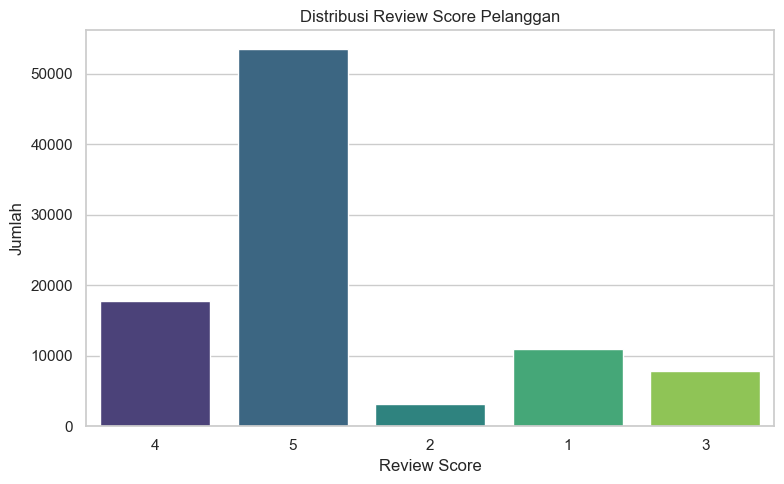

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(data=main_df, x='review_score', hue='review_score', palette='viridis', legend=False)
plt.title('Distribusi Review Score Pelanggan')
plt.xlabel('Review Score')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.savefig('Distribusi Review Score Pelanggan', dpi=300, bbox_inches="tight")
plt.show()


### 📈 Insight: Distribusi Review Score Pelanggan
1. Mayoritas pelanggan memberikan review yang sangat positif:

- Skor 5 mendominasi dengan jumlah yang jauh lebih tinggi dibandingkan skor lainnya. Ini menandakan bahwa pengalaman pelanggan secara umum sangat memuaskan.

- Skor 4 juga cukup signifikan, mengindikasikan sebagian pelanggan merasa puas namun ada ruang untuk perbaikan.

2. Jumlah review negatif (skor 1–2) relatif kecil, namun tetap penting untuk dianalisis lebih lanjut karena bisa menunjukkan masalah pada produk, pengiriman, atau layanan pelanggan dan menjadi peluang peningkatan kualitas layanan/logistik.

### Top 10 Kategori Produk

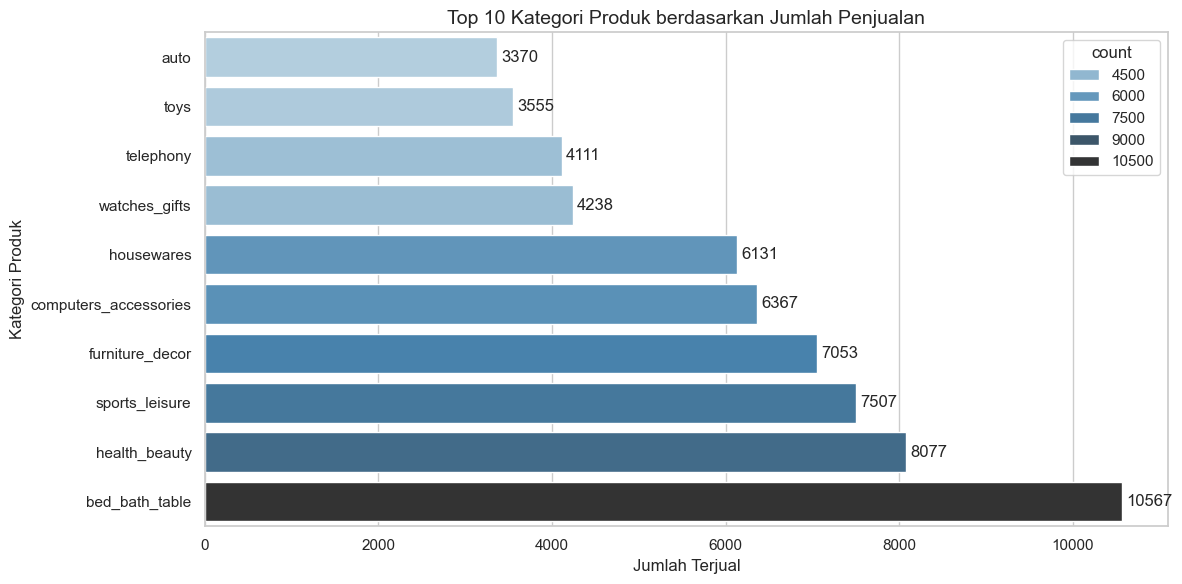

In [31]:
### Top 10 Kategori Produk
top10 = main_df['product_category_name_english'].value_counts().head(10)
top10_df = top10.reset_index()
top10_df.columns = ['category', 'count']

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='count', y='category', data=top10_df.sort_values(by='count'), hue='count', palette='Blues_d') 

plt.title('Top 10 Kategori Produk berdasarkan Jumlah Penjualan', fontsize=14)
plt.xlabel('Jumlah Terjual')
plt.ylabel('Kategori Produk')

# Tambahkan label ke ujung bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.savefig('Top 10 Kategori Produk berdasarkan Jumlah Penjualan', dpi=300, bbox_inches="tight")
plt.show()


### 📈 Insight: Top 10 Kategori Produk
1. Kategori `bed_bath_table` merupakan yang paling laris dengan hampir 12.000 penjualan, diikuti oleh `health_beauty` dan `sports_leisure`.
   Tiga kategori teratas ini menyumbang proporsi besar terhadap total penjualan, menunjukkan potensi untuk difokuskan dalam strategi pemasaran atau pengadaan stok.
3. Kategori lain seperti `auto`, `garden_tools`, dan `telephony` berada di posisi bawah top 10, tetapi tetap menunjukkan adanya permintaan yang stabil.


### Distribusi Metode Pembayaran

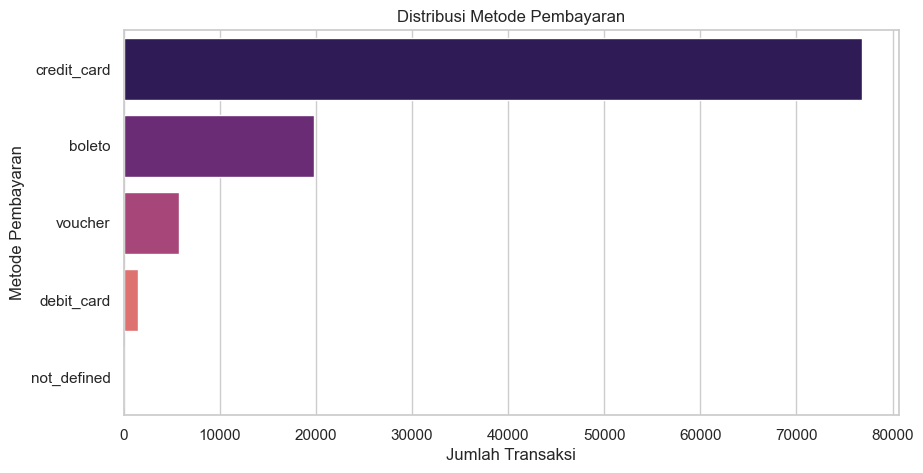

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(y=payments["payment_type"], order=payments["payment_type"].value_counts().index, palette="magma",hue=payments["payment_type"], legend=False)
plt.title("Distribusi Metode Pembayaran")
plt.xlabel("Jumlah Transaksi")
plt.ylabel("Metode Pembayaran")
plt.legend([], [], frameon=False)  # Menghapus legend
plt.savefig("Distribusi Metode Pembayaran", dpi=300, bbox_inches="tight")
plt.show()

### 📈 Insight: Distribusi Metode Pembayaran
- Mayoritas pembayaran dilakukan menggunakan credit card.
- Metode lain seperti boleto dan voucher juga digunakan.

### Customer Demographic (State & City)

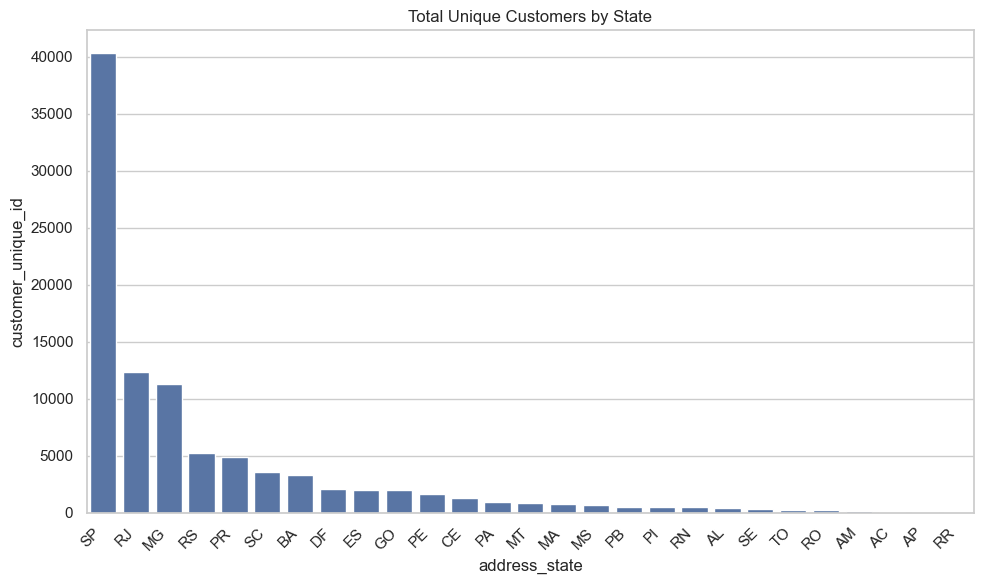

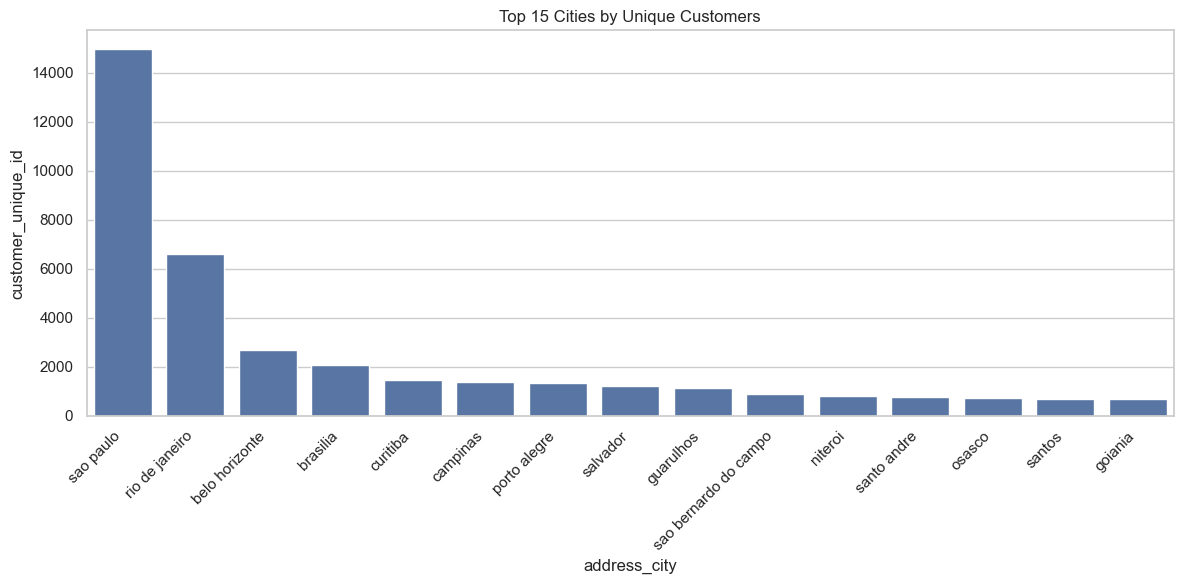

In [15]:
customers.rename(columns={
    'customer_state': 'address_state',
    'customer_city': 'address_city'
}, inplace=True)

state_customers = customers.groupby('address_state')['customer_unique_id'].nunique().reset_index()
state_customers = state_customers.sort_values(by='customer_unique_id', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='address_state', y='customer_unique_id', data=state_customers)
plt.title('Total Unique Customers by State')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Total Unique Customers by State', dpi=300, bbox_inches="tight")
plt.show()

city_customers = customers.groupby('address_city')['customer_unique_id'].nunique().reset_index()
city_customers = city_customers.sort_values(by='customer_unique_id', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='address_city', y='customer_unique_id', data=city_customers)
plt.title('Top 15 Cities by Unique Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Top 15 Cities by Unique Customers', dpi=300, bbox_inches="tight")
plt.show()

### 📈 Insight: Customer Demographic (State & City)
- 62% pelanggan berada di **São Paulo (45%)** dan **Rio de Janeiro (17%)**
- Kota-kota lain di Brazil menyumbang sisanya dengan kontribusi yang lebih kecil.

### Customer Behavior (Spending Category)

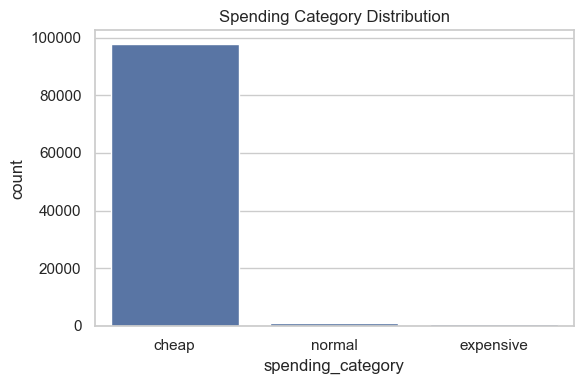

In [16]:
# Average order value per customer
avg_order_value = orders_items.groupby('customer_id')['total_order_value'].mean().reset_index()
avg_order_value = pd.merge(avg_order_value, customers, on='customer_id', how='left')

# Classify spending
def classify_spending(x):
    if x < 1000:
        return 'cheap'
    elif x <= 2500:
        return 'normal'
    else:
        return 'expensive'

avg_order_value['spending_category'] = avg_order_value['total_order_value'].apply(classify_spending)
avg_order_value.to_csv("eda_data.csv", index=False)

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='spending_category', data=avg_order_value, order=['cheap', 'normal', 'expensive'])
plt.title('Spending Category Distribution')
plt.tight_layout()
plt.savefig('Spending Category Distribution', dpi=300, bbox_inches="tight")
plt.show()


### 📈 Insight: Customer Behavior (Spending Category)
- Sebagian besar transaksi bernilai rendah (< 1.000 BRL), menunjukkan dominasi pembelian kebutuhan rumah tangga

## 5. Cohort Analysis


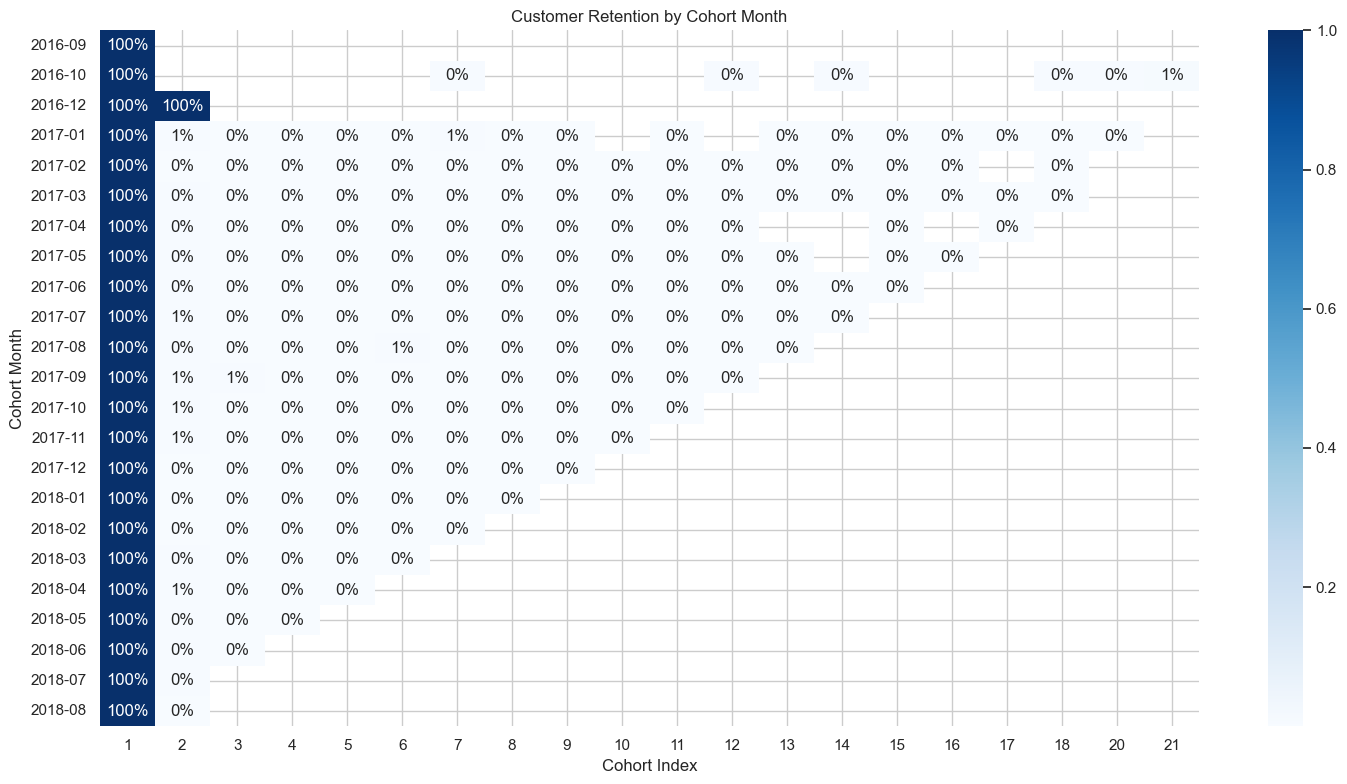

In [17]:
main_df['cohort_month'] = main_df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
main_df['cohort_index'] = ((main_df['order_purchase_timestamp'].dt.to_period('M') - main_df['cohort_month']).apply(lambda x: x.n) + 1)

cohort_group = main_df.groupby(['cohort_month', 'cohort_index'])['customer_unique_id'].nunique().reset_index()
cohort_size = cohort_group[cohort_group['cohort_index'] == 1][['cohort_month', 'customer_unique_id']]
cohort_size.rename(columns={'customer_unique_id': 'cohort_size'}, inplace=True)
cohort_group = cohort_group.merge(cohort_size, on='cohort_month')
cohort_group['retention_rate'] = cohort_group['customer_unique_id'] / cohort_group['cohort_size']

cohort_pivot = cohort_group.pivot(index='cohort_month', columns='cohort_index', values='retention_rate')

plt.figure(figsize=(15, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', cmap='Blues')
plt.title('Customer Retention by Cohort Month')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.savefig('Customer Retention by Cohort Month', dpi=300, bbox_inches="tight")
plt.show()

### 📈 Insight:  Cohort Analysis
1. Sebagian besar pelanggan hanya berbelanja satu kali dan hanya sebagian kecil pelanggan yang melakukan pembelian kedua dan seterusnya.
2. Retensi turun drastis di bulan kedua. Artinya perlu ada program loyalitas atau retargeting untuk meningkatkan repeat order.

## 6. Distribusi Kepuasan Pelanggan


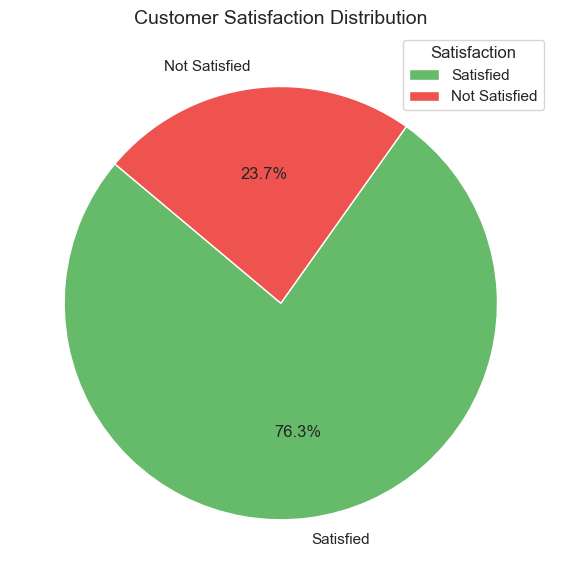

In [18]:
# Gabungkan data
orders_customers = pd.merge(orders, customers, on='customer_id', how='left')
orders_reviews = pd.merge(orders_customers, reviews, on='order_id', how='left')

# Konversi review_score ke numerik
orders_reviews['review_score'] = pd.to_numeric(orders_reviews['review_score'], errors='coerce')

# Hitung rata-rata skor review per pelanggan
avg_review_score = orders_reviews.groupby('customer_unique_id')['review_score'].mean().reset_index()

# Label puas atau tidak puas
avg_review_score['satisfaction'] = avg_review_score['review_score'].apply(lambda x: 'Satisfied' if x >= 4 else 'Not Satisfied')

# Hitung jumlah masing-masing
satisfaction_counts = avg_review_score['satisfaction'].value_counts()

# Visualisasi Pie Chart
import matplotlib.pyplot as plt

colors = ['#66bb6a', '#ef5350']
labels = satisfaction_counts.index

plt.figure(figsize=(6, 6))
plt.pie(satisfaction_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
plt.title('Customer Satisfaction Distribution', fontsize=14)
plt.legend(title='Satisfaction', loc='upper right')
plt.tight_layout()
plt.savefig('Customer Satisfaction Distribution', dpi=300, bbox_inches="tight")
plt.show()


### 📈 Insight: Distribusi Kepuasan Pelanggan
1. 77% Pelanggan Merasa Puas, Mayoritas pelanggan rata-rata memberi nilai ≥ 4.
2. Namun masih ada 23% yang tidak puas. Ini menjadi peluang untuk perbaikan layanan.

## 7. RFM Analysis & Segmentation


In [19]:
#preprasi data
main_df[pd.to_numeric(main_df['payment_value'], errors='coerce').isna()]
main_df['payment_value'] = main_df['payment_value'].astype(str)
main_df['payment_value'] = main_df['payment_value'].str.replace(r'[^0-9.]', '', regex=True)
main_df['payment_value'] = main_df['payment_value'].str.extract(r'(\d+\.\d+|\d+)', expand=False)
main_df['payment_value'] = pd.to_numeric(main_df['payment_value'], errors='coerce')


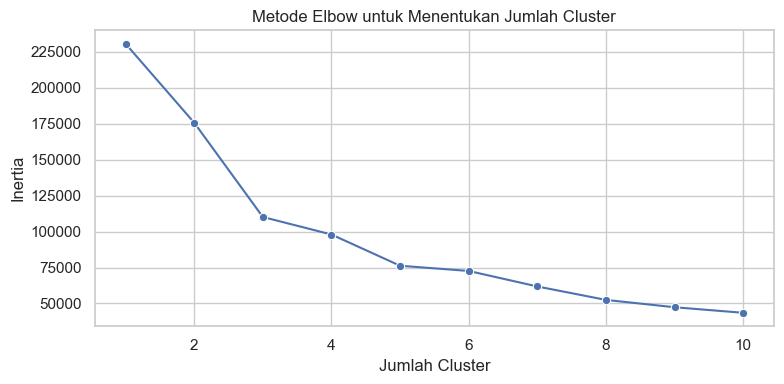

In [20]:
#Analisis RFM
rfm_df = main_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (main_df['order_purchase_timestamp'].max() - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
}).reset_index()

rfm_df.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

# Elbow Method untuk Clustering RFM ---
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
sns.lineplot(x=list(K), y=distortions, marker='o')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Analisis Hasil Elbow Method
Sumbu X: Jumlah cluster (k) dari 1 sampai 10.

Sumbu Y: Inertia (jumlah kuadrat jarak antar titik dengan pusat clusternya).

📌 Titik Elbow Terlihat di k = 4
Ada penurunan inertia yang tajam dari k=1 ke k=3, lalu mulai melandai setelah k=4.

k = 4 menunjukkan titik “tekukan” (elbow) di grafik, di mana penurunan inertia setelahnya tidak lagi signifikan.

Artinya, menambah cluster lebih dari 4 tidak memberikan manfaat signifikan dalam mengurangi inertia, hanya membuat model lebih kompleks.

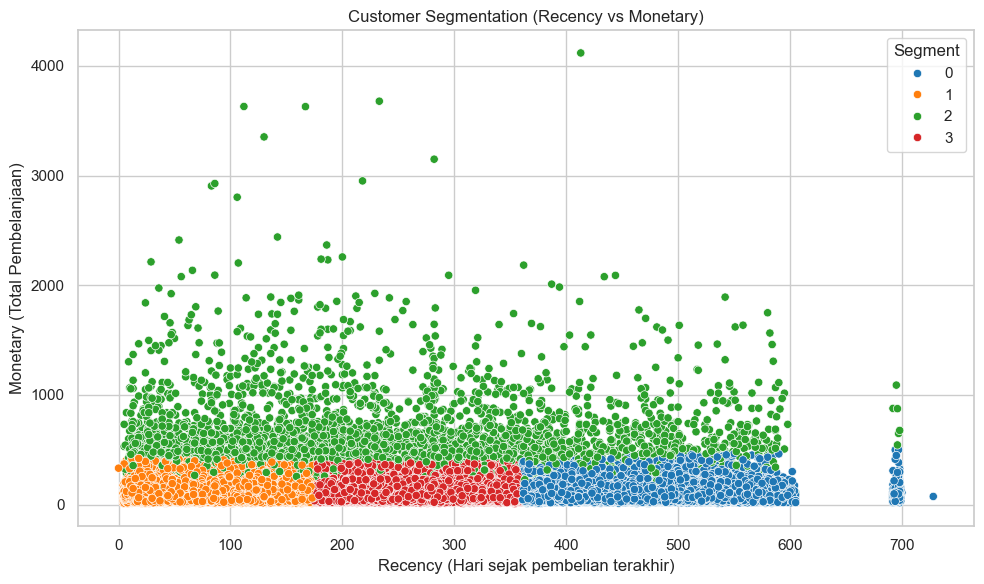

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Segment', palette='tab10')
plt.title('Customer Segmentation (Recency vs Monetary)')
plt.xlabel('Recency (Hari sejak pembelian terakhir)')
plt.ylabel('Monetary (Total Pembelanjaan)')
plt.tight_layout()
plt.savefig('Customer Segmentation (Recency vs Monetary)', dpi=300, bbox_inches="tight")
plt.show()

### 📈 Insight: Segmentasi Pelanggan Berdasarkan RFM

Segmentasi ini dilakukan dengan KMeans dan metode elbow, menghasilkan 4 segmen pelanggan berdasarkan Recency dan Monetary.

**Segmen 2 (Hijau) adalah segmen terbaik**: pelanggan ini cenderung baru berbelanja (recency rendah) dan memiliki total pembelanjaan tinggi. Mereka layak dijadikan prioritas dalam program loyalitas.

**Segmen 0 (Biru) dan Segmen 3 (Merah) berisi pelanggan dengan nilai belanja rendah dan recency tinggi** — ini adalah kandidat retargeting.

**Segmen 1 (Oranye) memiliki recency rendah tapi monetary masih kecil** — berpotensi ditingkatkan loyalitasnya melalui edukasi atau upselling.

## 8. Tren Penjualan Bulanan dan Harian

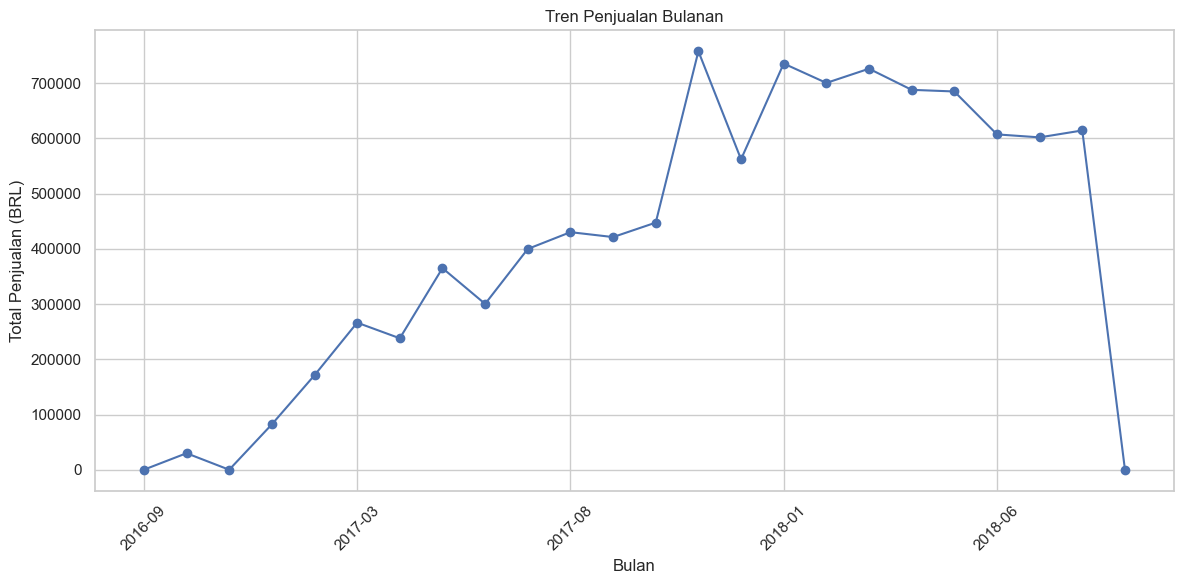

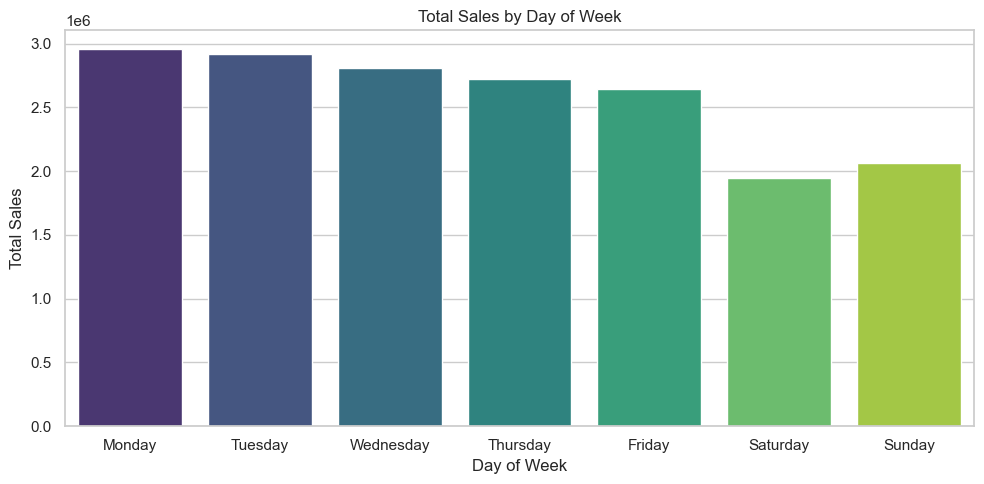

In [23]:
# Tren Penjualan Bulanan
monthly_sales = main_df.groupby('order_month')['payment_value'].sum()
plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', marker='o', color='b')
plt.title('Tren Penjualan Bulanan')
plt.ylabel('Total Penjualan (BRL)')
plt.xlabel('Bulan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Tren Penjualan Bulanan', dpi=300, bbox_inches="tight")
plt.show()

# Tren Penjualan Harian
# Add weekday
orders_items['day_name'] = orders_items['order_purchase_timestamp'].dt.day_name()

# Group by day
weekday_sales = orders_items.groupby('day_name')['total_order_value'].sum().reset_index()

# Reorder days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales['day_name'] = pd.Categorical(weekday_sales['day_name'], categories=days_order, ordered=True)
weekday_sales = weekday_sales.sort_values('day_name')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    x='day_name',
    y='total_order_value',
    data=weekday_sales,
    hue='day_name',         
    palette='viridis',
    legend=False            # supaya tidak muncul legenda
)
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.savefig('Total Sales by Day of Week', dpi=300, bbox_inches="tight")
plt.show()


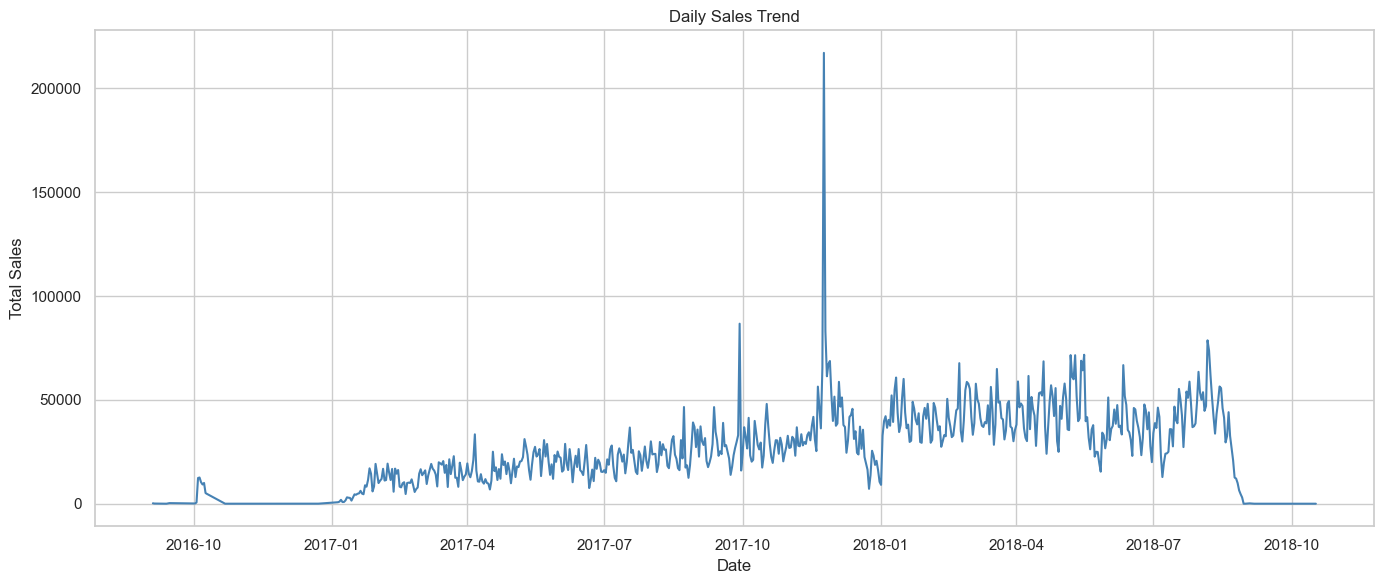

In [24]:
# Daily sales
orders_items['order_purchase_date'] = orders_items['order_purchase_timestamp'].dt.date
daily_sales = orders_items.groupby('order_purchase_date')['total_order_value'].sum().reset_index()

# Line plot
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['order_purchase_date'], daily_sales['total_order_value'], color='steelblue')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.savefig('Daily Sales Trend', dpi=300, bbox_inches="tight")
plt.show()


### 📈 Insight: Tren Penjualan Bulanan dan Harian
1. Pertumbuhan Penjualan bulanan yang Konsisten dan stabil meskipun terlihat ada beberapa fluktuasi.
2. Lonjakan penjualan mencapai puncaknya di sekitar bulan November 2017 dengan nilai lebih dari 1.600.000 BRL yang mengindikasikan adanya pola musiman atau promo (Black Friday).
3. Penjualan mingguan cenderung tinggi di awal minggu (Senin-Selasa), yang mengindikasikan pengguna aktif berbelanja di hari kerja. Promosi dapat difokuskan di awal minggu (Senin-Selasa) yang menunjukkan pola transaksi tinggi.
4. Penurunan signifikan di akhir periode data: Setelah mencapai puncak di Agustus 2018, terjadi penurunan yang sangat drastis pada bulan September 2018, bahkan penjualan hampir menyentuh angka nol atau sangat rendah. Ada kemungkinan terjadi peristiwa besar (misalnya, masalah teknis, perubahan kebijakan, masalah rantai pasok, penutupan operasional) yang secara drastis mempengaruhi penjualan di bulan tersebut atau adanya potensi kesalahan dalam pencatatan data untuk bulan tersebut.

## 9. Pareto Analysis: Product Categories vs Revenue


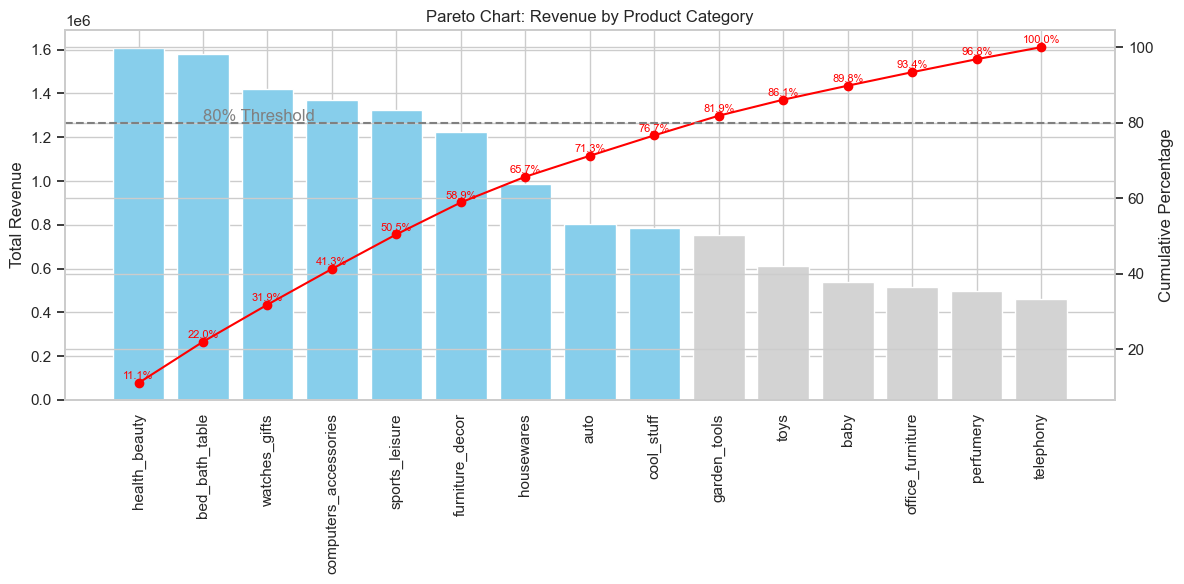

In [23]:
# Hitung total revenue per kategori produk
pareto_df = main_df.groupby('product_category_name_english')['total_order_value'].sum().reset_index()
pareto_df = pareto_df.sort_values(by='total_order_value', ascending=False)

# Ambil 15 kategori teratas
pareto_df = pareto_df.head(15).copy()

# Hitung cumulative percentage
pareto_df['cumulative_percentage'] = pareto_df['total_order_value'].cumsum() / pareto_df['total_order_value'].sum() * 100

# Tentukan batas kategori yang masuk 80%
pareto_df['color'] = ['skyblue' if x <= 80 else 'lightgray' for x in pareto_df['cumulative_percentage']]

# Plot Pareto Chart
fig, ax = plt.subplots(figsize=(12,6))

# Bar chart dengan warna berbeda berdasarkan threshold
ax.bar(pareto_df['product_category_name_english'], pareto_df['total_order_value'], color=pareto_df['color'])

# Line chart cumulative
ax2 = ax.twinx()
line = ax2.plot(pareto_df['product_category_name_english'], pareto_df['cumulative_percentage'], color='red', marker='o')

# Tambahkan label persentase pada tiap titik cumulative
for i, txt in enumerate(pareto_df['cumulative_percentage']):
    ax2.annotate(f"{txt:.1f}%", (i, pareto_df['cumulative_percentage'].iloc[i] + 1), color='red', fontsize=8, ha='center')

# Highlight 80% line
ax2.axhline(80, color='grey', linestyle='dashed')
ax2.text(1, 80.5, '80% Threshold', color='grey')

# Formatting
ax.set_ylabel('Total Revenue')
ax2.set_ylabel('Cumulative Percentage')
ax.set_xticks(range(len(pareto_df)))
ax.set_xticklabels(pareto_df['product_category_name_english'], rotation=90)
ax.set_title('Pareto Chart: Revenue by Product Category')

plt.tight_layout()
plt.savefig('Pareto Chart Revenue by Product Category', dpi=300, bbox_inches="tight")
plt.show()

### 📈 Insight: Pareto Analysis: Product Categories vs Revenue
1. **80% Revenue Disumbang oleh 9 Kategori Teratas (20% kategori produk)**  
   Hal ini ditunjukkan oleh titik merah (garis kumulatif) yang mencapai garis horizontal "80% Threshold" tepat di kategori ke-9.
2. Kategori-kategori tersebut mencakup `health_beauty`, `bed_bath_table`, `watches_gifts`, hingga `cool_stuff`.
3. Artinya, strategi bisnis seperti promosi, pengelolaan stok, dan pelayanan sebaiknya **diprioritaskan pada kategori-kategori utama ini** (highlight biru muda) untuk mencapai efisiensi dan peningkatan profit.
4. Kategori sisanya (warna abu-abu) menyumbang lebih kecil terhadap total revenue, namun tetap bisa dijadikan target untuk strategi jangka panjang atau diferensiasi.

## 10. Pelanggan Baru vs Lama

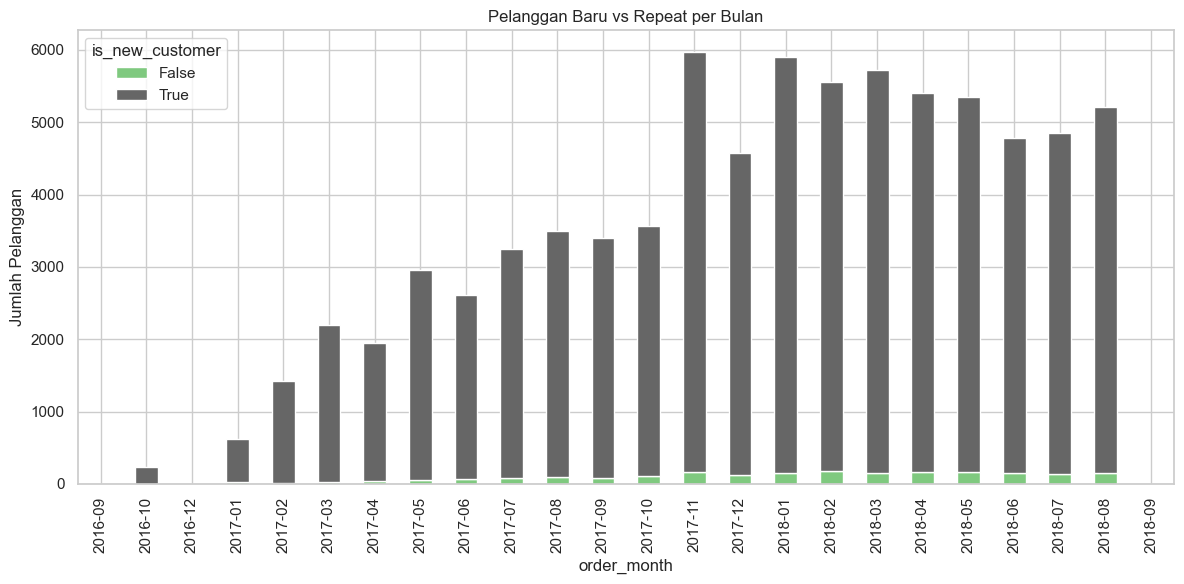

In [25]:
main_df['first_order'] = main_df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')
main_df['is_new_customer'] = main_df['order_purchase_timestamp'] == main_df['first_order']
new_repeat = main_df.groupby(['order_month', 'is_new_customer'])['customer_unique_id'].nunique().unstack()
new_repeat.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Accent')
plt.title('Pelanggan Baru vs Repeat per Bulan')
plt.ylabel('Jumlah Pelanggan')
plt.tight_layout()
plt.savefig('Pelanggan Baru vs Repeat per Bulan', dpi=300, bbox_inches="tight")
plt.show()

### 📈 Insight: Pelanggan Baru vs Lama
1. Sebagian besar pelanggan yang melakukan pembelian setiap bulannya adalah pelanggan repeat (direpresentasikan oleh warna abu-abu gelap). Jumlah pelanggan baru (warna hijau muda) relatif sangat kecil dibandingkan dengan pelanggan repeat.
2. Jumlah total pelanggan (baru + repeat) yang aktif melakukan transaksi per bulan menunjukkan tren peningkatan yang signifikan dari akhir tahun 2016 hingga awal tahun 2018.
3. Kontribusi pelanggan baru stabil namun jumlahnya kecil. Untuk pertumbuhan jangka panjang, pelanggan baru hari ini penting karena mereka akan menjadi pelanggan repeat di masa depan.
4. Ketergantungan pada Pelanggan Repeat. Strategi retensi pelanggan akan menjadi sangat krusial untuk menjaga kelangsungan bisnis dan pertumbuhan pendapatan.

## 11. Kesimpulan & Rekomendasi


### 🔍 Kesimpulan Utama
- Konsentrasi pelanggan tertinggi berada di kota São Paulo dan Rio de Janeiro.
- Sebagian besar transaksi bernilai rendah (< 1.000 BRL), menunjukkan dominasi pembelian kebutuhan rumah tangga.
- 77% pelanggan merasa puas dengan layanan (rating ≥ 4), dan rasio review per transaksi tinggi (~1).
- Penjualan mingguan cenderung tinggi di awal minggu (Senin–Selasa), menunjukkan pola belanja aktif di hari kerja.
- Produk seperti `health_beauty`, `bed_bath_table`, dan `watches_gifts` merupakan kontributor utama pendapatan.
- Kategori yang populer saat lonjakan penjualan juga sudah populer sebelumnya, menunjukkan bahwa promosi memperkuat tren yang sudah ada.
- Retensi pelanggan masih rendah; strategi loyalitas dan retargeting sangat dibutuhkan.
- Pelanggan aktif terus bertumbuh, mengindikasikan potensi pertumbuhan pasar yang positif.
- Metode pembayaran paling dominan adalah kartu kredit.

### 💡 Rekomendasi Bisnis
1. Promosi terjadwal sebaiknya difokuskan di awal minggu (Senin–Selasa) untuk memanfaatkan lonjakan aktivitas belanja.
2. Pastikan stok tersedia untuk kategori favorit seperti `health_beauty`, `bed_bath_table`, dan `watches_gifts`.
3. Bangun program loyalitas atau keanggotaan eksklusif bagi pelanggan berulang, terutama dari kota besar.
4. Perkuat kerja sama dengan penyedia kartu kredit karena dominasinya sebagai metode pembayaran.
5. Lakukan segmentasi pelanggan dan market basket analysis:
   - *Segmentasi pelanggan* untuk menyusun strategi pemasaran yang lebih efisien.
   - *Market basket analysis* untuk menemukan pola produk yang sering dibeli bersama guna mendorong cross-selling dan bundling.
6. Fokuskan kampanye pemasaran pada 20% kategori produk yang memberikan kontribusi terbesar terhadap pendapatan.
7. Manfaatkan analisis RFM untuk mengidentifikasi pelanggan bernilai tinggi untuk strategi retargeting.
8. Optimalkan promosi akhir tahun untuk memanfaatkan potensi kenaikan penjualan musiman.

---

📈 Dengan insight ini, Olist dapat mengoptimalkan strategi pemasaran, operasional, dan retensi pelanggan berdasarkan data.


## 12. Analisis Tambahan (Root Cause & Contrast)

### Root-cause-analysis
[Top](#Daftar-Isi) 

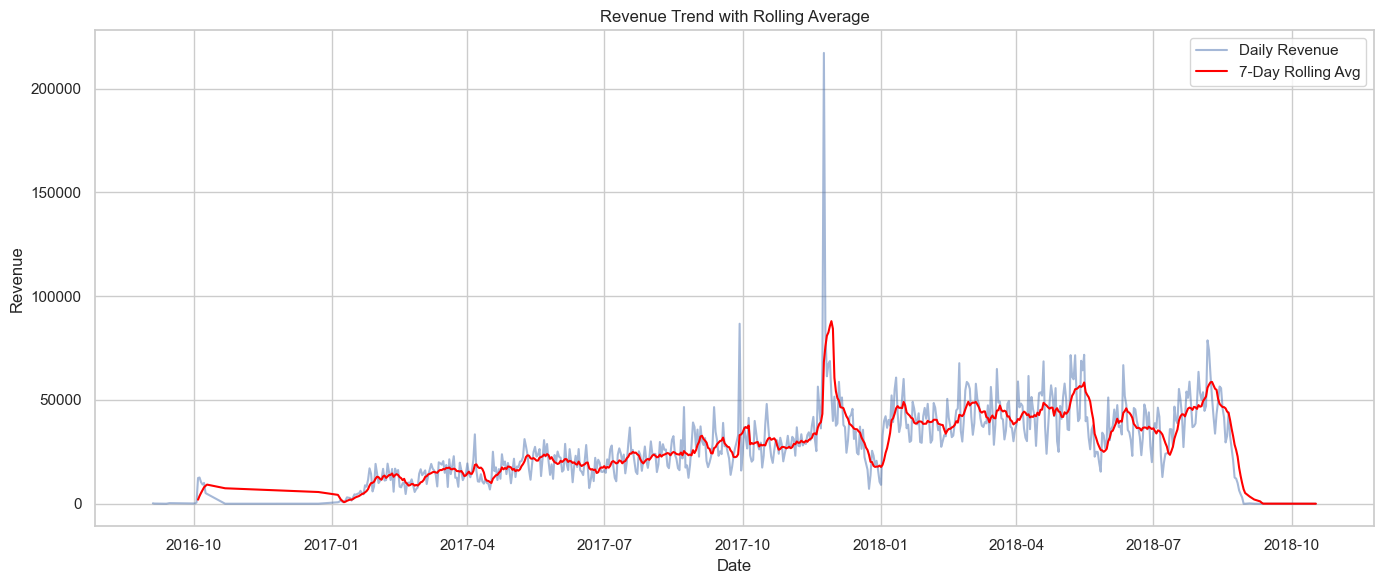

In [26]:
# Rolling average
daily_sales['order_purchase_date'] = pd.to_datetime(daily_sales['order_purchase_date'])
daily_sales['rolling_revenue'] = daily_sales['total_order_value'].rolling(window=7).mean()

# Plot spike detection
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['order_purchase_date'], daily_sales['total_order_value'], label='Daily Revenue', alpha=0.5)
plt.plot(daily_sales['order_purchase_date'], daily_sales['rolling_revenue'], label='7-Day Rolling Avg', color='red')
plt.title('Revenue Trend with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# Periods
spike_period = ('2017-11-01', '2017-11-30')
before_period = ('2017-10-01', '2017-10-31')

orders_items['order_purchase_date'] = pd.to_datetime(orders_items['order_purchase_date'])

# Filter
revenue_before = orders_items[
    (orders_items['order_purchase_date'] >= before_period[0]) &
    (orders_items['order_purchase_date'] <= before_period[1])
]
revenue_spike = orders_items[
    (orders_items['order_purchase_date'] >= spike_period[0]) &
    (orders_items['order_purchase_date'] <= spike_period[1])
]

# AOV
print("AOV BEFORE spike:", revenue_before['total_order_value'].mean())
print("AOV DURING spike:", revenue_spike['total_order_value'].mean())

# Top categories
top_cat_before = pd.merge(revenue_before, products, on='product_id', how='left')
top_cat_spike = pd.merge(revenue_spike, products, on='product_id', how='left')

print("Top categories BEFORE spike:\n", top_cat_before['product_category_name_english'].value_counts().head(5))
print("\nTop categories DURING spike:\n", top_cat_spike['product_category_name_english'].value_counts().head(5))


AOV BEFORE spike: 168.12601653513718
AOV DURING spike: 159.412551644547
Top categories BEFORE spike:
 product_category_name_english
bed_bath_table           545
sports_leisure           471
furniture_decor          379
health_beauty            361
computers_accessories    322
Name: count, dtype: int64

Top categories DURING spike:
 product_category_name_english
bed_bath_table     975
furniture_decor    783
sports_leisure     612
health_beauty      584
garden_tools       550
Name: count, dtype: int64


### Contrast-analysis
[Top](#Daftar-Isi) 

In [28]:
# Summary table
summary = pd.DataFrame({
    'Metric': ['Total Orders', 'Average Order Value'],
    'Before Spike': [
        revenue_before['order_id'].nunique(),
        revenue_before['total_order_value'].mean()
    ],
    'During Spike': [
        revenue_spike['order_id'].nunique(),
        revenue_spike['total_order_value'].mean()
    ]
})
summary


,Metric,Before Spike,During Spike
0,Total Orders,4631.000000,7544.000000
1,Average Order Value,168.126017,159.412552


📈 Perhitungan AOV Change (Average Order Value)

Before: Rp168.13
During: Rp159.41

**(159.41 − 168.13)/ 168.13 × 100 = −5.18%**

🔻 Artinya: AOV turun 5.18% selama spike dibanding sebelum spike.

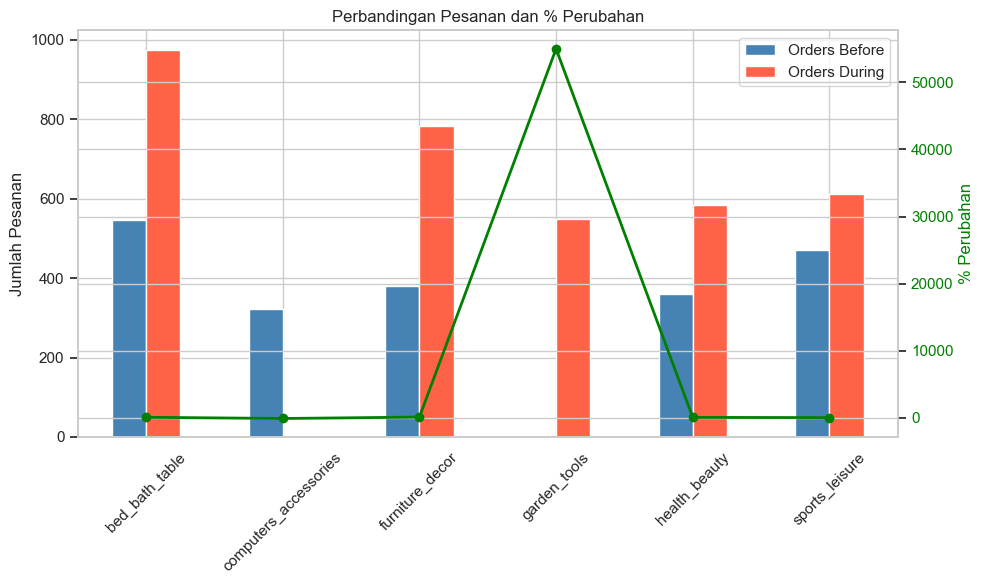

In [29]:
# Hitung 5 kategori terlaris sebelum dan selama spike
cat_before_df = top_cat_before['product_category_name_english'].value_counts().reset_index()
cat_before_df.columns = ['Category', 'Orders Before']
cat_before_df = cat_before_df.head(5)

cat_spike_df = top_cat_spike['product_category_name_english'].value_counts().reset_index()
cat_spike_df.columns = ['Category', 'Orders During']
cat_spike_df = cat_spike_df.head(5)


# Gabungkan dua DataFrame untuk membandingkan
contrast_categories = pd.merge(cat_before_df, cat_spike_df, on='Category', how='outer').fillna(0)

contrast_categories['% Change'] = (
    (contrast_categories['Orders During'] - contrast_categories['Orders Before']) / 
    contrast_categories['Orders Before'].replace(0, 1)
) * 100


fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar untuk orders
contrast_categories[['Orders Before', 'Orders During']].plot(
    kind='bar',
    ax=ax1,
    color=['steelblue', 'tomato'],
    position=0.5
)

ax1.set_ylabel('Jumlah Pesanan')
ax1.set_xticks(range(len(contrast_categories)))
ax1.set_xticklabels(contrast_categories['Category'], rotation=45)
ax1.set_title('Perbandingan Pesanan dan % Perubahan')

# Line chart untuk % change
ax2 = ax1.twinx()
ax2.plot(contrast_categories['% Change'], color='green', marker='o', linestyle='-', linewidth=2, label='% Change')
ax2.set_ylabel('% Perubahan', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()
plt.show()





#### Kategori bed_bath_table menjadi paling populer sebelum dan selama spike.